In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

,timestamp,usage,temperature
0,1652518498,4.65,49.173
1,1652518508,5.20,48.686
2,1652518518,4.15,48.199
3,1652518528,4.20,48.199
4,1652518538,4.75,48.686
...,...,...,...
5277,1652571268,16.15,49.660
5278,1652571278,15.75,50.634
5279,1652571288,15.80,51.608
5280,1652571298,16.50,49.660


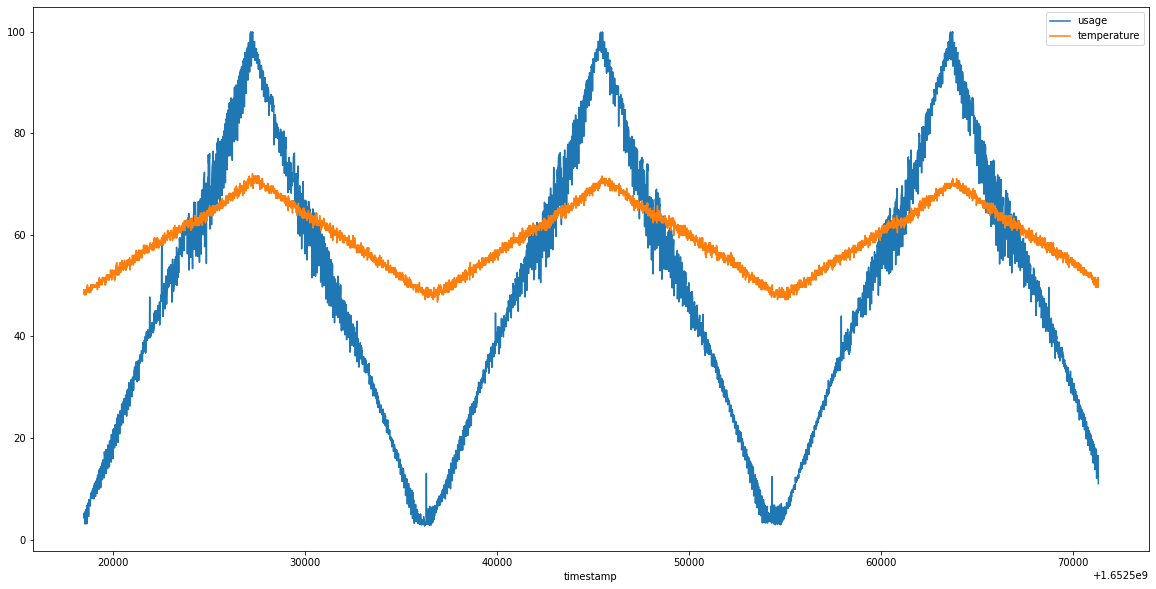

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/def-au1t/AGH_8_AI-Project/master/out_rpi_fan_25_steps1_baseline.csv')
df.sort_values(by=['timestamp'], inplace=True)
df.plot(x='timestamp', figsize=(20,10))
df

# Gaussian Mixture

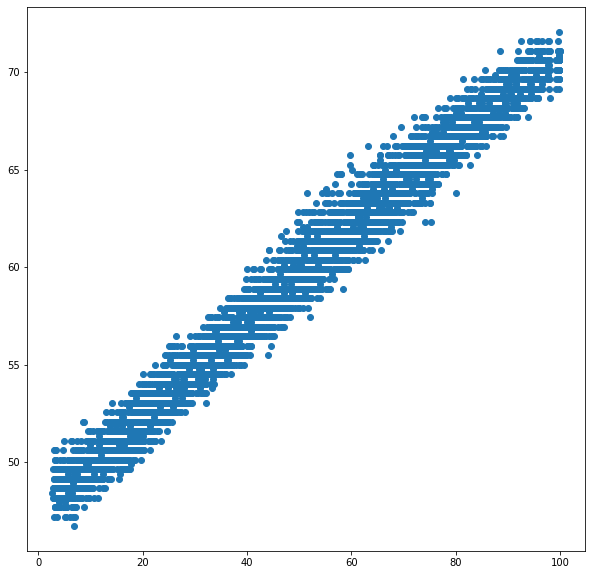

In [ ]:
df_out = pd.DataFrame(columns=['usage', 'temperature'])
df_out['usage'] = df['usage']
df_out['temperature'] = df['temperature']
# plot data
plt.figure(figsize=(10,10))
plt.scatter(df['usage'], df_out['temperature'], cmap='summer')
plt.show()

-13.494521008869125


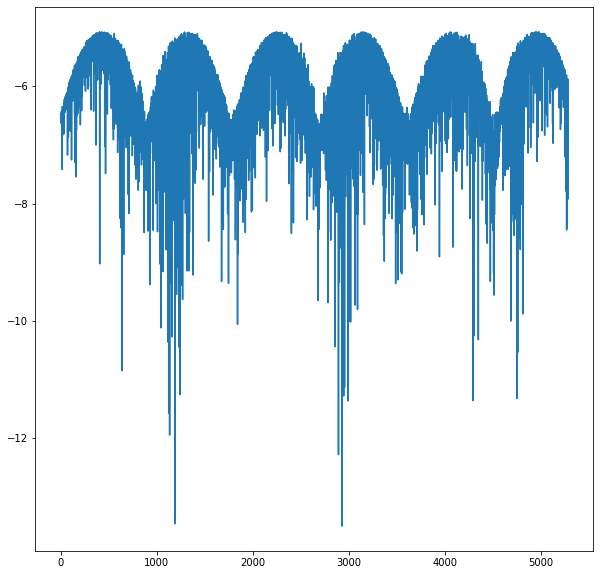

In [ ]:
from sklearn.mixture import GaussianMixture
# create gm model
gm = GaussianMixture(n_components=1, covariance_type='full').fit(df_out)
scores = gm.score_samples(df_out)
thresh = np.min(scores)
print(thresh)
plt.figure(figsize=(10,10))
plt.plot(scores)
plt.show()

,timestamp,usage,temperature
0,1652571268,16.15,49.660
1,1652571278,15.75,50.634
2,1652571288,15.80,51.608
3,1652571298,16.50,49.660
4,1652571308,11.00,50.147
...,...,...,...
3299,1652604258,50.15,80.341
3300,1652604268,52.30,80.828
3301,1652604278,54.15,81.315
3302,1652604288,53.95,80.341


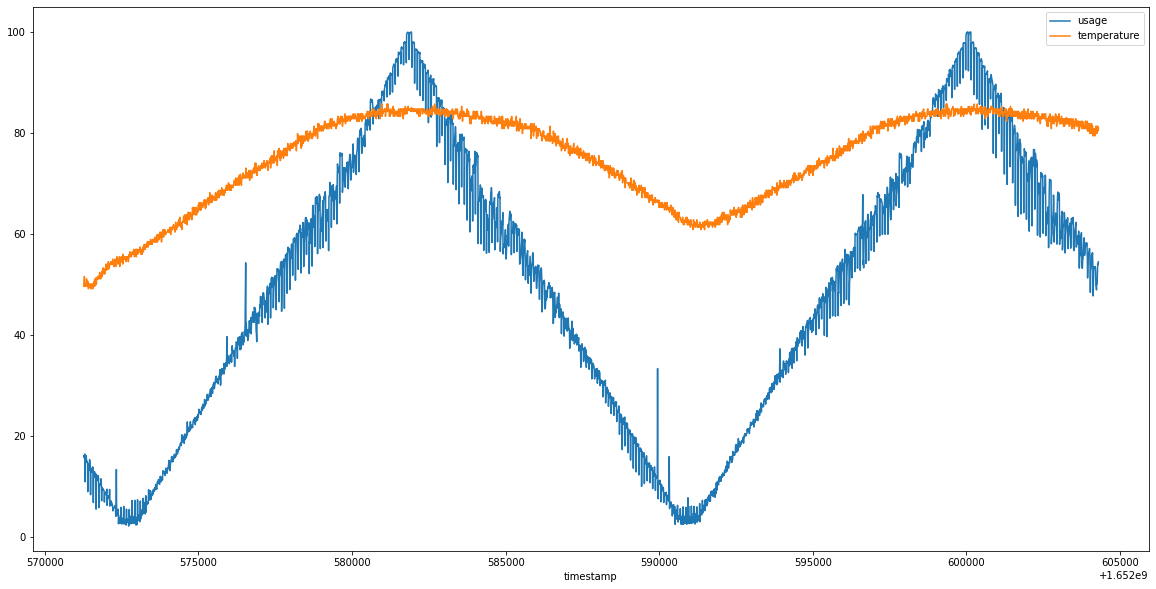

In [ ]:
## check on dataset with anomaly
anomaly = pd.read_csv('https://raw.githubusercontent.com/def-au1t/AGH_8_AI-Project/master/out_rpi_fan_25_steps1_covered.csv')
anomaly.sort_values(by=['timestamp'], inplace=True)
anomaly.plot(x='timestamp', figsize=(20,10))
anomaly

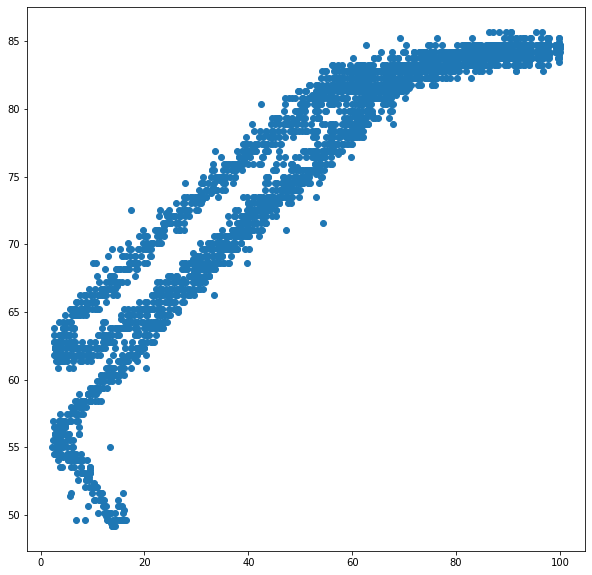

In [ ]:
anomaly_out = pd.DataFrame(columns=['usage', 'temperature'])
anomaly_out['usage'] = anomaly['usage']
anomaly_out['temperature'] = anomaly['temperature']
plt.figure(figsize=(10,10))
plt.scatter(anomaly_out['usage'], anomaly_out['temperature'], cmap='summer')
plt.show()

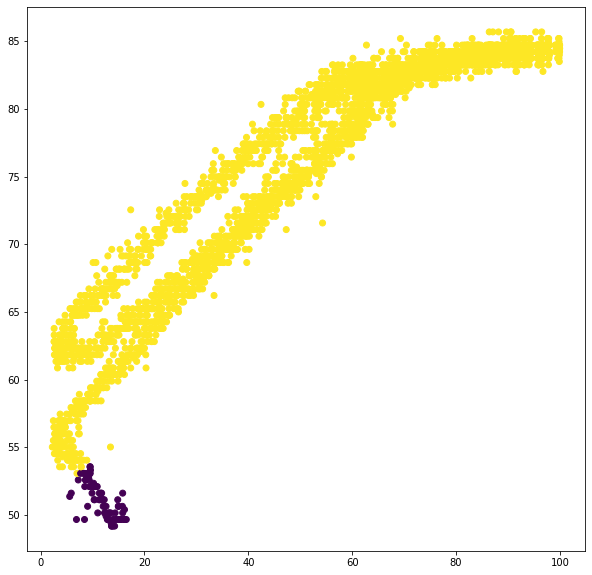

In [ ]:
anomaly_scores = gm.score_samples(anomaly_out)
outliers = anomaly_scores < thresh
plt.figure(figsize=(10,10))
plt.scatter(anomaly_out['usage'], anomaly_out['temperature'], c=outliers)
plt.show()

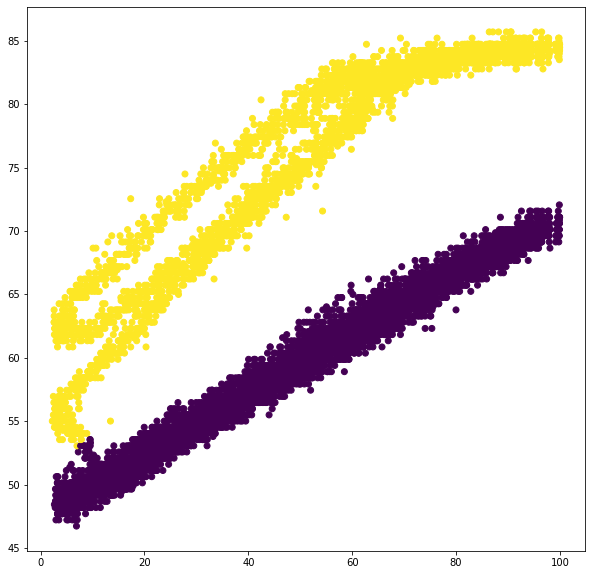

In [ ]:
combined = pd.concat([anomaly_out, df_out])
combined_scores = gm.score_samples(combined)
outliers = combined_scores < thresh
plt.figure(figsize=(10,10))
plt.scatter(combined['usage'], combined['temperature'], c=outliers)
plt.show()

In [ ]:
# save to file
np.save('gm_weights', gm.weights_, allow_pickle=False)
np.save('gm_means', gm.means_, allow_pickle=False)
np.save('gm_covariances', gm.covariances_, allow_pickle=False)
np.save('gm_threshold', thresh, allow_pickle=False)

# reload
means = np.load('gm_means.npy')
covar = np.load('gm_covariances.npy')
threshold = np.load('gm_threshold.npy')
loaded_gm = GaussianMixture(n_components = len(means), covariance_type='full')
loaded_gm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
loaded_gm.weights_ = np.load('gm_weights.npy')
loaded_gm.means_ = means
loaded_gm.covariances_ = covar

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but GaussianMixture was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


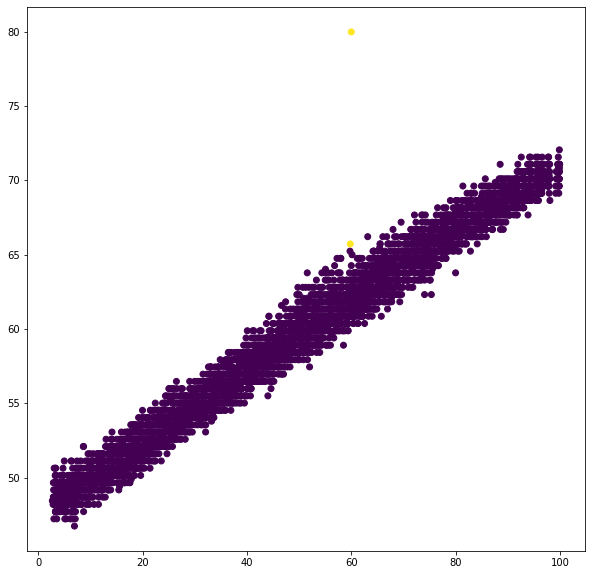

In [ ]:
anomaly_out = pd.DataFrame(columns=['usage', 'temperature'])
anomaly_out['usage'] = [60.0] 
anomaly_out['temperature'] = [80.0] 

combined = pd.concat([anomaly_out, df_out])
combined_scores = loaded_gm.score_samples(combined)
outliers = combined_scores < threshold
plt.figure(figsize=(10,10))
plt.scatter(combined['usage'], combined['temperature'], c=outliers)
plt.show()

In [ ]:
from zipfile import ZipFile

In [ ]:
file = ZipFile('gm.zip', 'w')
file.write('gm_covariances.npy')
file.write('gm_means.npy')
file.write('gm_threshold.npy')
file.write('gm_weights.npy')
file.close()